## 50. データの入手・整形

In [1]:
#各種インポート
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
#データ読み込み
df = pd.read_csv('newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

In [3]:
#データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

In [4]:
#データの分割
train, valid_test = train_test_split(df,test_size=0.2,shuffle=True,random_state=56,stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test,test_size=0.5,shuffle=True,random_state=56,stratify=valid_test['CATEGORY'])

In [5]:
#TSVにして出力
train.to_csv('train.txt',sep='\t',index=False)
valid.to_csv('valid.txt',sep='\t',index=False)
test.to_csv('test.txt',sep='\t',index=False)

In [6]:
#データ数の確認
print('学習データ:')
print(train['CATEGORY'].value_counts())
print('検証データ:')
print(valid['CATEGORY'].value_counts())
print('評価データ:')
print(test['CATEGORY'].value_counts())

学習データ:
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
検証データ:
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64
評価データ:
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出

In [7]:
import string
import re

def seikei(target):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    target = target.translate(table)
    target = target.lower()
    target = re.sub(r'[0-9]+','0',target)
    
    return target

In [8]:
#データを結合
df = pd.concat([train, valid, test], axis=0)
#インデックスを付け直す
df.reset_index(drop=True, inplace=True)
#データを成形する
df['TITLE'] = df['TITLE'].map(seikei)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid = df[ : len(train) + len(valid)]
test = df[len(train) + len(valid) : ]

#TF-IDF
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])
X_test = vec_tfidf.transform(test['TITLE'])


In [10]:
# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]


In [11]:
# TSVにして保存
X_train.to_csv('train.feature.txt', sep='\t', index=False)
X_valid.to_csv('valid.feature.txt', sep='\t', index=False)
X_test.to_csv('test.feature.txt', sep='\t', index=False)

## 52. 学習

In [12]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lr = LogisticRegression(random_state=56, max_iter=10000)
lr.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=56)

## 53. 予測

In [13]:
def predict(lr,X):
    return [lr.predict_proba(X),lr.predict(X)]

In [14]:
predict_train = predict(lr,X_train)
predict_test = predict(lr,X_test)

## 54. 正解率の計測

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [16]:
accuracy_train = accuracy_score(train['CATEGORY'], predict_train[1])
accuracy_test = accuracy_score(test['CATEGORY'], predict_test[1])
print('正解率(学習データ)')
print(accuracy_train)
print('正解率(評価データ)')
print(accuracy_test)

正解率(学習データ)
0.9261512542119057
正解率(評価データ)
0.874251497005988


## 55. 混同行列の作成

In [17]:
cm_train = confusion_matrix(train['CATEGORY'], predict_train[1])
cm_test = confusion_matrix(test['CATEGORY'], predict_test[1])
print('混同行列(学習データ)')
print(cm_train)
print('混同行列(評価データ)')
print(cm_test)

混同行列(学習データ)
[[4339   95    8   59]
 [  59 4163    4    9]
 [  88  127  499   14]
 [ 182  139    5  894]]
混同行列(評価データ)
[[525  21   3  14]
 [  6 521   1   1]
 [ 19  26  42   4]
 [ 38  31   4  80]]


## 56. 適合率，再現率，F1スコアの計測

In [18]:
import numpy as np
def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], predict_test[1], average=None, labels=['b', 'e', 't', 'm'])
  precision= np.append(precision, precision_score(y_true, y_pred, average='micro')) 
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro')) 

  # 再現率
  recall = recall_score(test['CATEGORY'], predict_test[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], predict_test[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

In [19]:
print(calculate_scores(test['CATEGORY'],predict_test[1]))

             適合率       再現率     F1スコア
b       0.892857  0.932504  0.912250
e       0.869783  0.984877  0.923759
t       0.808081  0.522876  0.634921
m       0.840000  0.461538  0.595745
マイクロ平均  0.874251  0.874251  0.874251
マクロ平均   0.852680  0.725449  0.766669


## 57. 特徴量の重みの確認

In [20]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lr.classes_, lr.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  print(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b
        1      2      3      4       5       6      7          8        9   \
重要度上位  fed   bank    ecb  china  stocks     oil   euro  obamacare  ukraine   
重要度下位  and  ebola  video  study     her  google  aereo        the      she   

           10  
重要度上位  yellen  
重要度下位    star  


【カテゴリ】e
           1           2       3      4        5      6      7         8   \
重要度上位   chris  kardashian     her   film  wedding   paul   star       she   
重要度下位  update          us  google  china       gm  apple  study  facebook   

            9      10  
重要度上位      kim  movie  
重要度下位  billion   says  


【カテゴリ】m
             1      2      3        4       5      6       7       8   \
重要度上位     ebola  study    fda   cancer    drug   mers  health   cases   
重要度下位  facebook     gm  apple  climate  amazon  sales     ceo  google   

            9      10  
重要度上位  doctors  could  
重要度下位  twitter   deal  


【カテゴリ】t
           1      2         3          4        5         6        7   \
重要度上位  goo

## 58. 正則化パラメータの変更

In [21]:
parameter = np.logspace(-5,5,10,base=10)
result = []
for c in parameter:
    clf = LogisticRegression(random_state=56, max_iter=10000,C=c)
    clf.fit(X_train, train['CATEGORY'])
    
    predict_train = predict(clf,X_train)
    predict_valid = predict(clf,X_valid)
    predict_test = predict(clf,X_test)
    
    accuracy_train = accuracy_score(train['CATEGORY'], predict_train[1])
    accuracy_valid = accuracy_score(valid['CATEGORY'], predict_valid[1])
    accuracy_test = accuracy_score(test['CATEGORY'], predict_test[1])
    
    result.append([c,accuracy_train,accuracy_valid,accuracy_test])    

In [22]:
import matplotlib.pyplot as plt

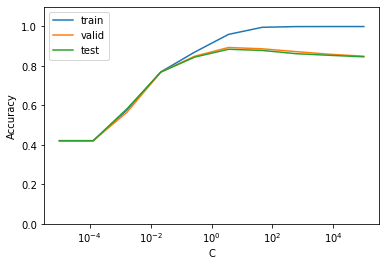

In [23]:
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索

In [38]:
solvers = ['newton-cg','lbfgs','liblinear','sag','saga']
result = {}
for solver in solvers:
    clf = LogisticRegression(random_state=56, max_iter=10000,solver=solver)
    clf.fit(X_train, train['CATEGORY'])
    
    predict_valid = predict(clf,X_valid)
    accuracy_valid = accuracy_score(valid['CATEGORY'], predict_valid[1])
    
    result.setdefault(solver,accuracy_valid)
    


In [39]:
print(max(result,key=result.get))

newton-cg


In [40]:
clf = LogisticRegression(random_state=56, max_iter=10000,solver='newton-cg')
clf.fit(X_train, train['CATEGORY'])
predict_test = predict(clf,X_test)
accuracy_test = accuracy_score(test['CATEGORY'], predict_test[1])

In [41]:
print(accuracy_test)

0.874251497005988


In [42]:
print(result)

{'newton-cg': 0.8832335329341318, 'lbfgs': 0.8824850299401198, 'liblinear': 0.8772455089820359, 'sag': 0.8832335329341318, 'saga': 0.8832335329341318}
